In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2FeatureExtractor, Wav2Vec2Model
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchaudio
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time

from plot_utils import save_model
from dataset import CustomDataset, CustomDataset2, CustomDatasetSplitZeros, CustomDatasetSplitRepeat

2023-12-13 11:22:16.187937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
class Wav2Vec2Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        self.feature_extractor = self.model.feature_extractor
        
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(127744, 1)
        self.bn1 = nn.BatchNorm1d(1) # batch norm
        self.relu = nn.ReLU()
        #self.fc2 = nn.Linear(64, 4)
        #self.bn2 = nn.BatchNorm1d(4) # batch norm
        #self.relu = nn.ReLU()
        #self.fc3 = nn.Linear(4, 1)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, input_values):
        #print(input_values.shape)
        #x = self.model(input_values).values()
        x = self.feature_extractor(input_values)
        #x = self.feature(input_values)
        #x = self.pooling(x[0])
        x = self.pooling(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x) #batch norm
        x = self.relu(x)
        #x = self.fc2(x)
        #x = self.bn2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.softmax(x)
        return x

    
    def fit(self, train_dataloader, val_dataloader=None, max_epochs=10, lr=0.000001, clip_value=1.0):
        #print(torch.cuda.is_available())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        val_accuracy_old = 0
        train_loss_all = []
        validation_loss_all = []
        
        for epoch in range(max_epochs):
            print('--------------------------------------')
            print(f'EPOCH {epoch+1}')
            self.train()
            train_loss = 0.0
            
            for inputs, labels in train_dataloader:
                inputs = inputs.to(torch.float32)
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                
                if torch.isnan(outputs).any().item():
                    print('OUTPUT IS NAN')
                    return
                            
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                optimizer.step()
                
                train_loss +=loss.item()
            train_avg_loss = train_loss / len(train_dataloader)
            print(f'Training loss {train_avg_loss:.4f}')
            train_loss_all.append(train_avg_loss)
                
            if val_dataloader is not None:
                self.eval()
                
                with torch.no_grad():
                    val_loss = 0.0
                    correct = 0
                    total = 0
                
                    for inputs, labels in val_dataloader:
                        inputs = inputs.to(torch.float32)
                        outputs = self.forward(inputs)
                        #probabilities = nn.ReLU(outputs)
                        probabilities = torch.sigmoid(outputs)
                        loss = criterion(outputs, probabilities)
                        val_loss += loss.item()
                        #_, pred = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        predictions = (probabilities > 0.5).float()
                        #correct += (pred == labels).sum().item()
                        correct += torch.sum(predictions == labels).item()
            val_avg_loss = val_loss / len(val_dataloader)
            print(f'Validation loss: {val_avg_loss}')
            validation_loss_all.append(val_avg_loss)
            val_accuracy = correct / total
            print(f'Validation accuracy {val_accuracy} ({correct} out of {total})')
            
            
            if val_accuracy >= val_accuracy_old:
                val_accuracy_old = val_accuracy
                save_model(name='Simple', model=self, optimizer=optimizer, epoch=epoch, val=val_accuracy)
                
        return train_loss_all, validation_loss_all
                
    def test(self, test_dataloader, weight_path):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        checkpoint = torch.load(weight_path)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.eval()
        
        correct = 0
        total = 0

        all_predictions = []
        all_labels = []
        all_audios = []
        all_probabilities = []
        
        for inputs, labels in test_dataloader:            
            
            outputs = self.forward(inputs)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).int()
            
            #_, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            labels = labels.int()
            #correct += (predicted == labels).sum().item()
            correct += torch.sum(predicted == labels).item()
            
            predicted = predicted.tolist()
            label = labels.tolist()
            audio = inputs.tolist()
            probability = probabilities.tolist()
            
            all_audios.append(audio)
            all_labels.append(label)
            all_predictions.append(predicted)
            all_probabilities.append(probability)
        
        test_accuracy = correct / total
        print(f'Test accuracy: {test_accuracy}')
        
        return all_audios, all_labels, all_predictions, all_probabilities

In [3]:
X_train, y_train, n_train, X_val, y_val, n_val, X_test, y_test, n_test = CustomDatasetSplitRepeat('data_id_new.csv')

X: (2871, 820, 410)
y: (2871, 820, 410)
id: (70, 20, 10)
X: (3097, 894, 433)
y: (3097, 894, 433)
id: (3097, 894, 433)


In [4]:
if __name__ == "__main__":
    ts = time.time()


    
    print("Start")
    torch.cuda.empty_cache()
    model = Wav2Vec2Classifier()
    #model.to(torch.device('cuda:0'))
    #model = model.to('cpu')

    train = CustomDataset2(X=X_train, y=y_train)
    val = CustomDataset2(X=X_val, y=y_val)

    trainloader = DataLoader(train, batch_size=32, drop_last=True, num_workers=0, shuffle=True)
    valloader = DataLoader(val, batch_size=32, drop_last=True, num_workers=0, shuffle=False)
    
    print('Starting training')
    train_loss, val_loss = model.fit(train_dataloader=trainloader, val_dataloader=valloader, max_epochs=20, clip_value=1.0)
    print(time.time() - ts)
    

Start


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training
--------------------------------------
EPOCH 1
Training loss 0.7394
Validation loss: 0.6806660493214926
Validation accuracy 0.5625 (486 out of 864)
New model, weights saved
--------------------------------------
EPOCH 2
Training loss 0.7081
Validation loss: 0.6745415307857372
Validation accuracy 0.5902777777777778 (510 out of 864)
New model, weights saved
--------------------------------------
EPOCH 3
Training loss 0.6845
Validation loss: 0.6674555628388016
Validation accuracy 0.6493055555555556 (561 out of 864)
New model, weights saved
--------------------------------------
EPOCH 4
Training loss 0.6664
Validation loss: 0.6670916919355039
Validation accuracy 0.6597222222222222 (570 out of 864)
New model, weights saved
--------------------------------------
EPOCH 5
Training loss 0.6476
Validation loss: 0.6586572196748521
Validation accuracy 0.6898148148148148 (596 out of 864)
New model, weights saved
--------------------------------------
EPOCH 6
Training loss 0.6321
V

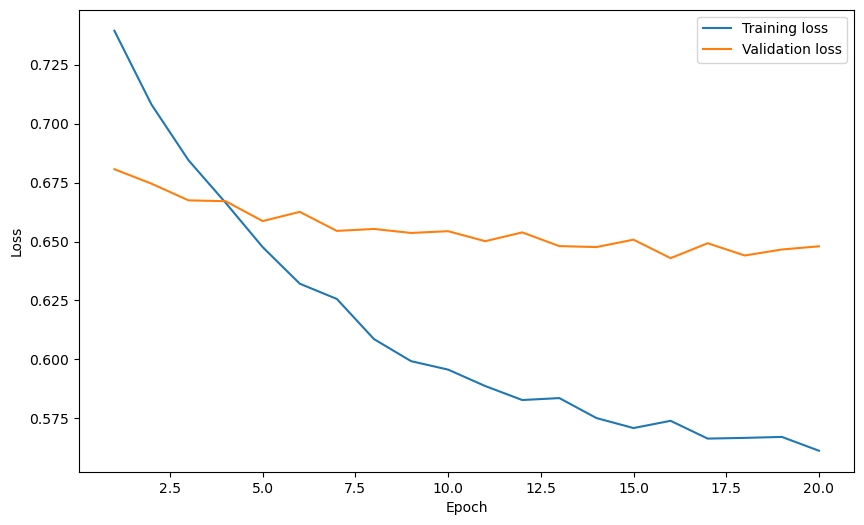

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,21), train_loss, label='Training loss')
plt.plot(range(1,21), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
w = 'weights/checkpoint_Simple_epoch_4_acc_0.6597222222222222.pt'

torch.cuda.empty_cache()

test = CustomDataset2(X=X_test, y=y_test)
testloader = DataLoader(test, batch_size=16, drop_last=True, num_workers=0, shuffle=True)

model_test = Wav2Vec2Classifier()
all_audios, all_labels, all_predictions, all_probabilities = model_test.test(test_dataloader=testloader, weight_path=w)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test accuracy: 0.5046296296296297


[Text(0, 0.5, 'PD'), Text(0, 1.5, 'HC')]

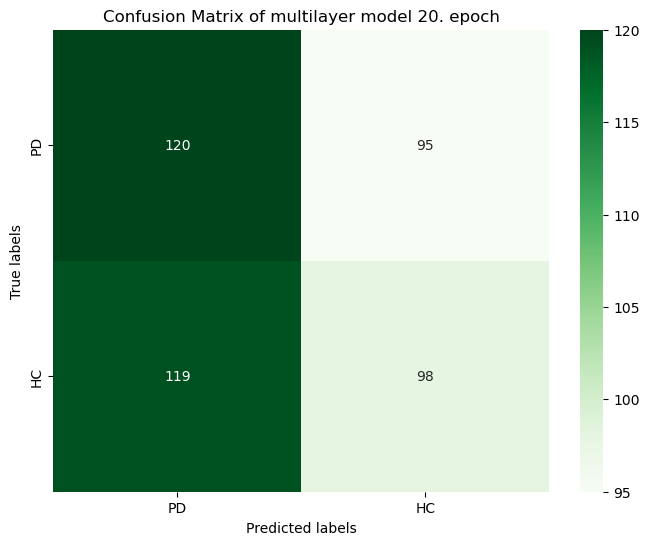

In [8]:

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dim_all_labels = list(chain.from_iterable(all_labels))
dim_all_predictions = list(chain.from_iterable(all_predictions))

cm = confusion_matrix(dim_all_labels, dim_all_predictions)

f = plt.figure(figsize=(8,6))
ax= f.add_subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of multilayer model 20. epoch')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC'])


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test accuracy: 0.5949074074074074


[Text(0, 0.5, 'PD'), Text(0, 1.5, 'HC')]

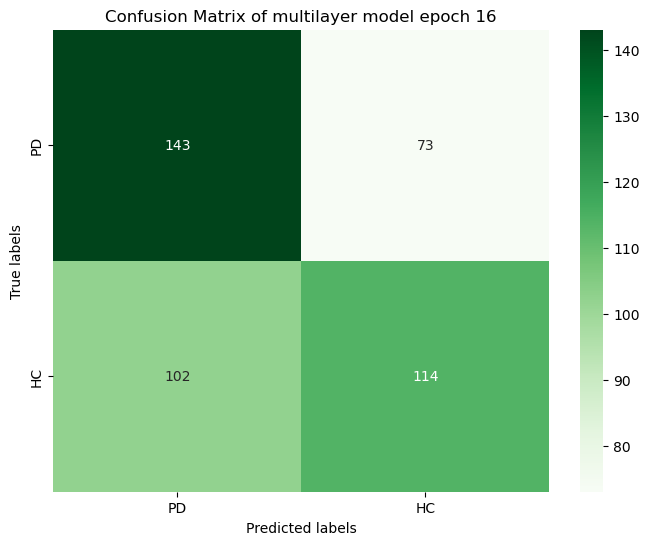

In [10]:
w = 'weights/checkpoint_Simple_epoch_16_acc_0.7534722222222222.pt'

torch.cuda.empty_cache()

test = CustomDataset2(X=X_test, y=y_test)
testloader = DataLoader(test, batch_size=16, drop_last=True, num_workers=0, shuffle=True)

model_test = Wav2Vec2Classifier()
all_audios, all_labels, all_predictions, all_probabilities = model_test.test(test_dataloader=testloader, weight_path=w)


dim_all_labels = list(chain.from_iterable(all_labels))
dim_all_predictions = list(chain.from_iterable(all_predictions))

cm = confusion_matrix(dim_all_labels, dim_all_predictions)

f = plt.figure(figsize=(8,6))
ax= f.add_subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Greens')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of multilayer model epoch 16')
ax.xaxis.set_ticklabels(['PD', 'HC'])
ax.yaxis.set_ticklabels(['PD', 'HC'])